# Altitude Data Engineering
Geo vis group - predicting sea level rise

Overview:

- **get_gdal** Given a latitude / longitude (gps) coordinate pair, download the corresponding GDAL image of the geography.
    - if needed, make multiple smaller requests in order to download entire dataset, and combine them into one
- **map_altitudes** Given a GDAL image and X altitude ranges (eg: 0 - 10 meters, 10 - 20 meters, etc.), output polygon shape coordinates on the map for the given altitude ranges.
    - keep GPS coordinates in final polygon dataset
    - Idea: Multipass sparse matrix with convolutions
- **combine_polygons** Given two polygons and their gps coordinates, combine them into a single shape with gps coordinates loadable into mapbox. 



In [244]:
#example to download packages
#import sys
#!{sys.executable} -m pip install elevation

In [245]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation 
import scipy as scipy

In [257]:
#See: https://github.com/bopen/elevation
#or run: 
#eio clip -o Hawaii.tif --bounds -156.09 19.00 -154.81 20.26

#the format is: 
#eio clip -o Hawaii.tif --bounds long1 lat1 long2 lat2
# Below we have long1 -156.70 and lat1 20.78

#
#!eio clip -o data/maui_001.tif --bounds -156.70 20.83 -155.00 22.00
#!eio clip -o data/Rome-30m-DEM.tif --bounds 12.35 41.8 12.65 42

# downtown section of the seattle waterfront
#!eio clip -o data/seattle_dt_001.tif --bounds -122.36 47.59 -122.33 47.62

#larger slice of downtown area
#!eio clip -o data/seattle_dt_002.tif --bounds -122.39 47.59 -122.32 47.63

#greater seattle area
!eio clip -o data/seattle_gt_003.tif --bounds -122.44 47.51 -122.24 47.71

#seattle large area
#todo

#arlington
#!eio clip -o data/arlington_001.tif --bounds -122.10 48.17 -122.07 48.19

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.80adee900a5e4ff292b01f27cee22193.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -122.44 47.71 -122.24 47.51 SRTM1.80adee900a5e4ff292b01f27cee22193.vrt /Users/blakedallen/go/src/github.com/blakedallen/MIDS/W209/geo-viz-group/data/seattle_gt_003.tif
rm -f SRTM1.80adee900a5e4ff292b01f27cee22193.vrt


In [249]:
#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26
filename = "data/seattle_gt_003.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

print(data_array.shape)

#i,j
#longtitude -156.70 --> -156.00
#latitude   20.83 --> 21.00
data_array = np.flip(data_array, axis=0)

#save to csv
#np.savetxt("data/locations/hawaii_big_island.csv", data_array, delimiter=",")


sliced = []
for x in range(0,data_array.shape[0],100):
    sliced_x = []
    for y in range(0,data_array.shape[1],100):
        #print(data_array[x][y])
        sliced_x.append(data_array[x][y])
    sliced.append(sliced_x)

(720, 720)


In [247]:
lower = -200
upper = 140
step = 10
levels = list(range(lower, upper, step))
print(levels)

[-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]


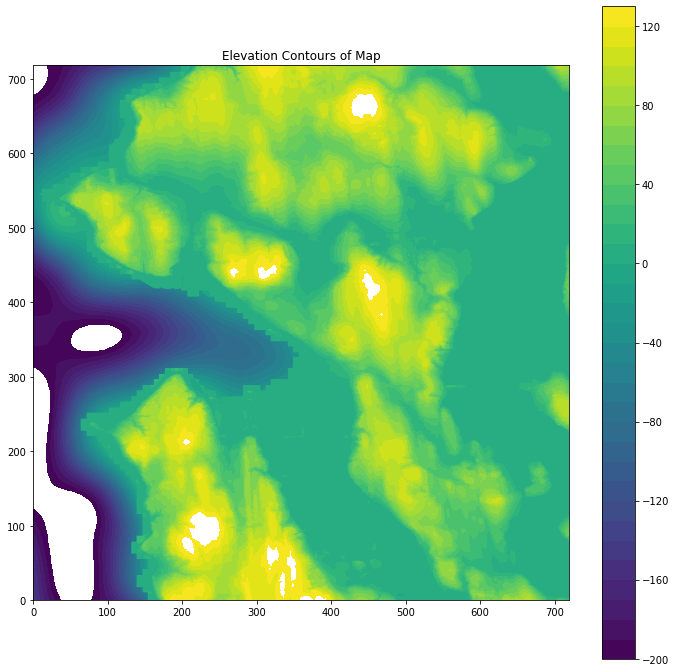

In [250]:
#Plot our data with Matplotlib's 'contourf'
%matplotlib inline
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Map")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [251]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)



def toGEO(i,j, bottom_left, top_right):
    """ given an i,j index, will return (lon,lat,elevation)"""
    ele = data_array[i][j]
    lon = translate(i, 0, data_array.shape[0], bottom_left[0], top_right[0])
    lat = translate(j, 0, data_array.shape[1], bottom_left[1], top_right[1])
    return (lon,lat,ele)

def toSparse(arr, cutoff=(0.0,10.0), char=1, nan=0):
    """ given a 1d array and cutoff will create a sparse matrix
        representation of the array based on the cutoff range
        Note: cutoff range is by default inclusive on the lower value [x,y)
    """
    def mapTo(elem, cutoff, char, nan):
        if elem < cutoff[0]:
            return nan
        elif elem >= cutoff[1]:
            return nan
        else:
            return char
    sparse = [mapTo(elem, cutoff, char, nan) for elem in arr]
    return np.array(sparse)

def filterElev(arr, cutoff=(0.0,10.0), nan=0):
    """ Very similar to toSparse, but keeps the elevation data
        given a 1d array and cutoff will create a sparse matrix
        representation of the array based on the cutoff range
        Note: cutoff range is by default inclusive on the lower value [x,y)
    """
    def mapTo(elem, cutoff, nan):
        if elem < cutoff[0]:
            return nan
        elif elem >= cutoff[1]:
            return nan
        else:
            return elem
    sparse = [mapTo(elem, cutoff, nan) for elem in arr]
    return np.array(sparse)


In [252]:
#create a dataset for each level
#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26

#TODO, create custom rects for each of these 
#elevations
#export these as datasets (geocoordinates)

matrices = {} #mapping of water level range <int> --> <sparse matrix>
sparse_levels = list(range(0, 200, 10))
base_level = 0.0
for level in sparse_levels:
    nl = level + step
    matrix = []
    for row in data_array:
        #row = toSparse(row, cutoff=(base_level, nl))
        row = filterElev(row, cutoff=(base_level, nl))
        matrix.append(row)
    m = np.asarray(matrix)
    key = nl
    matrices[key] = m



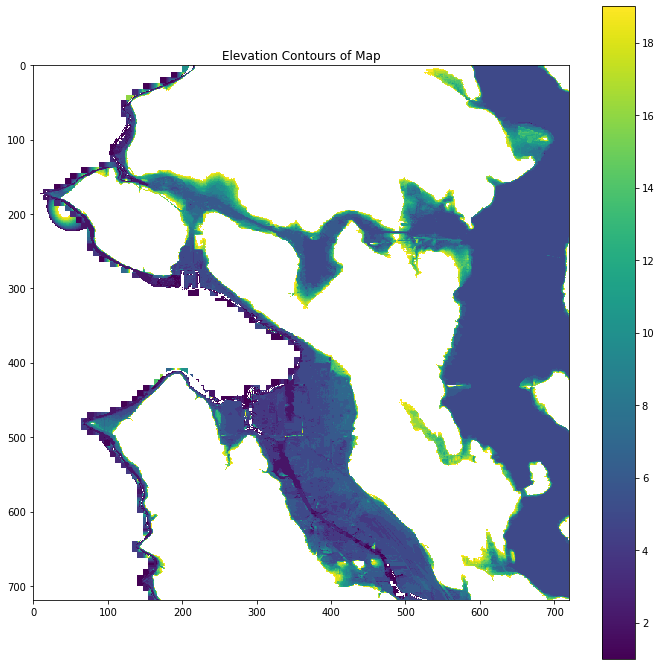

In [258]:
#Plot our elevation matrix to see results
#plt.spy(matrices[10])

#pick our altitude size here
m = matrices[20]

#mask anywhere that has 0
zeros = np.ma.masked_where(m == 0, m)
zeros = np.flip(zeros, axis=0)

fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
#plt.contourf(m, cmap = "viridis", levels = sparse_levels)
plt.imshow(zeros, cmap="viridis", interpolation='none')
plt.title("Elevation Contours of Map")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Note:
# You can just render an image and then overlay that
# see: https://docs.mapbox.com/mapbox-gl-js/example/image-on-a-map/

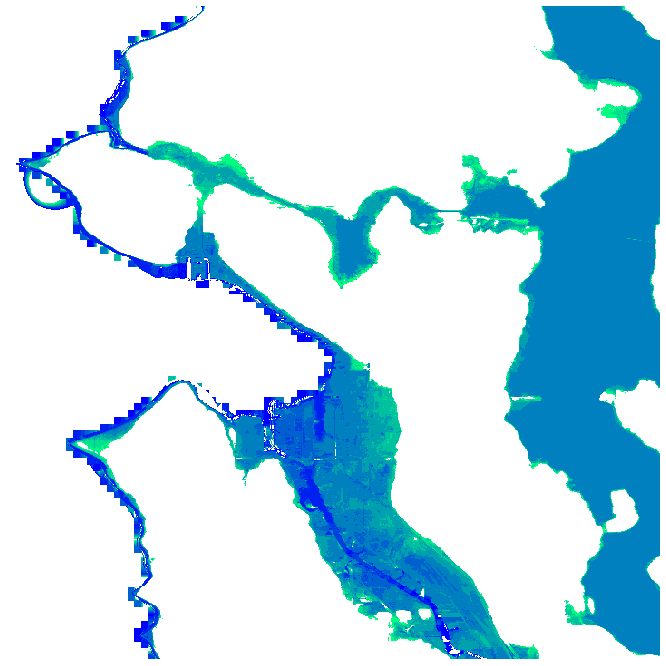

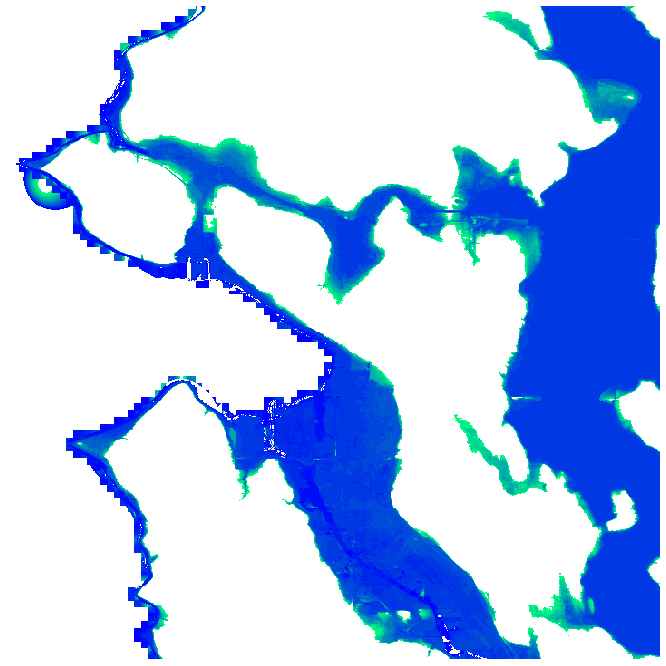

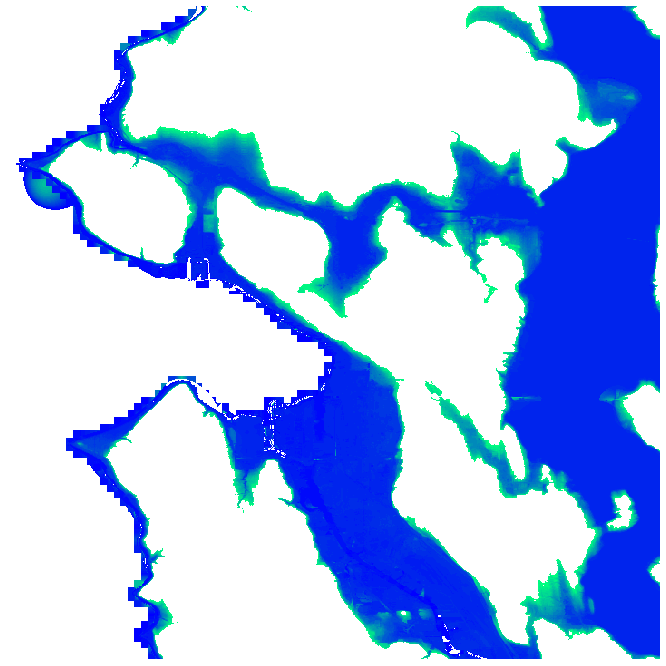

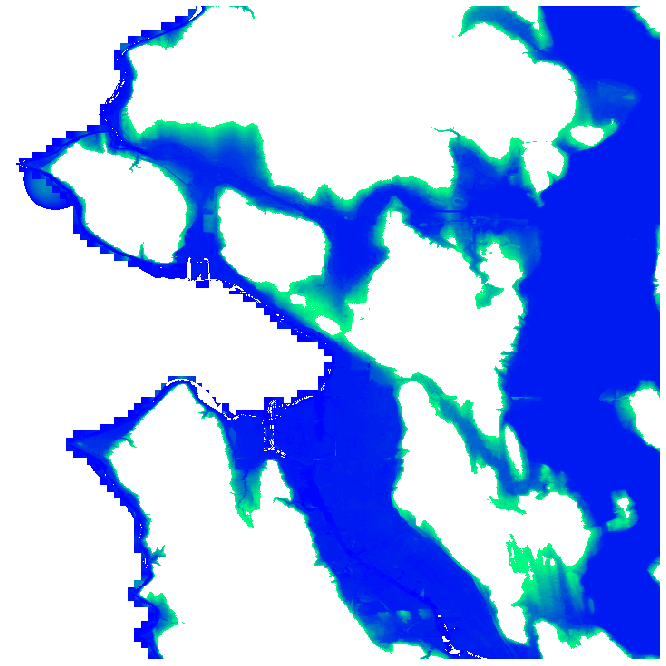

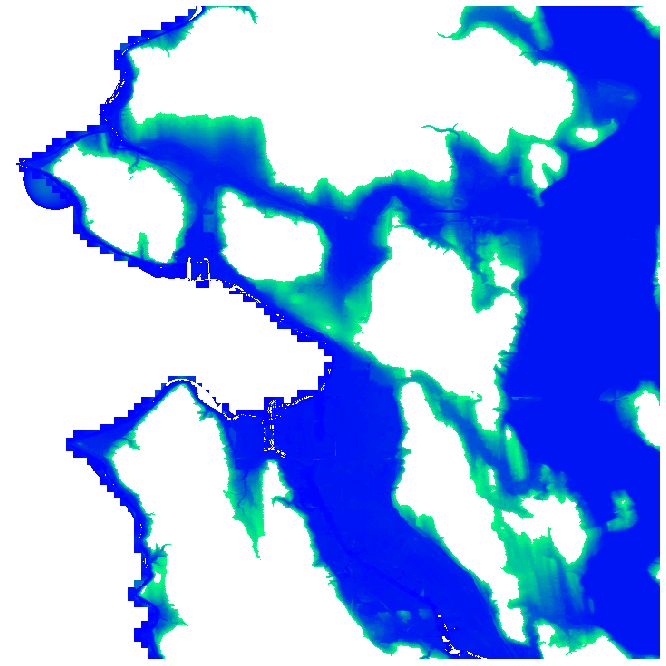

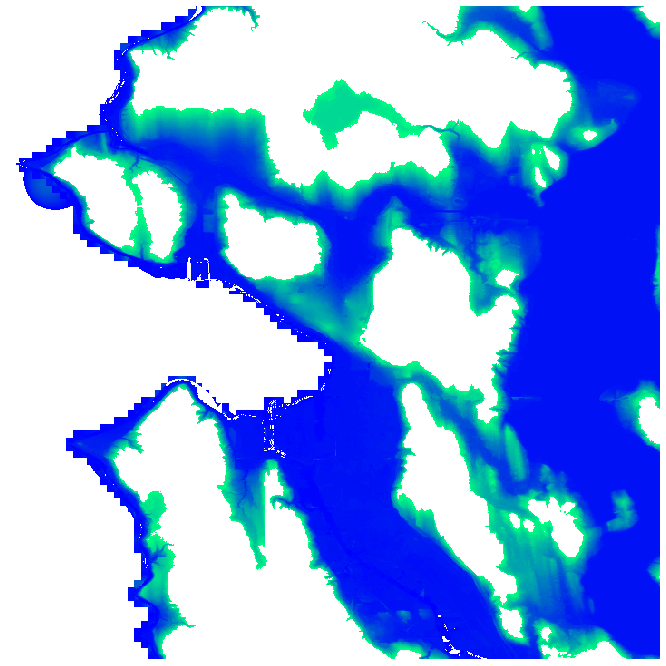

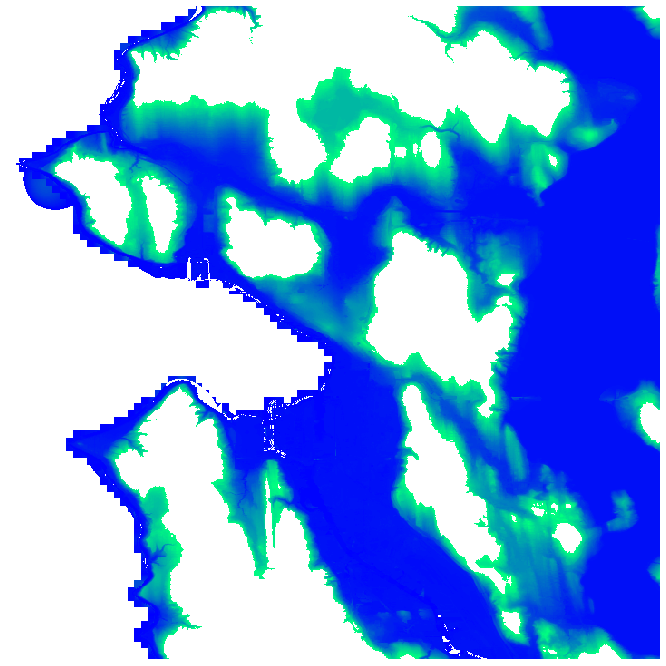

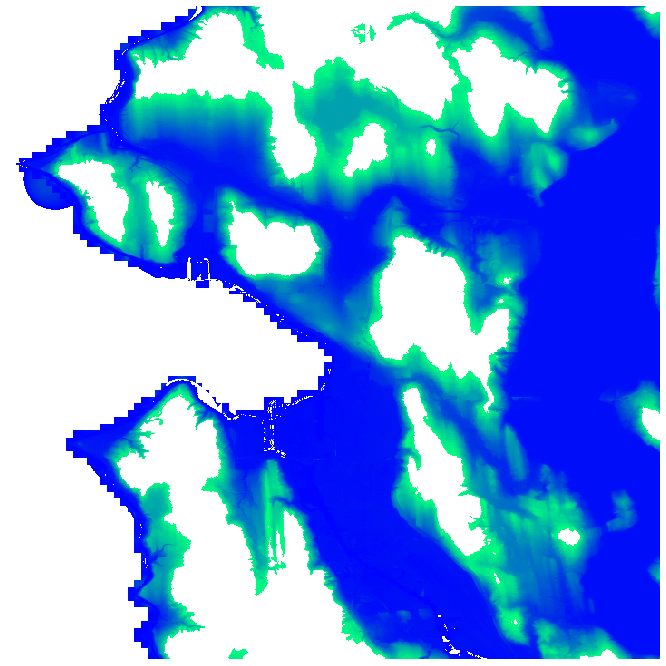

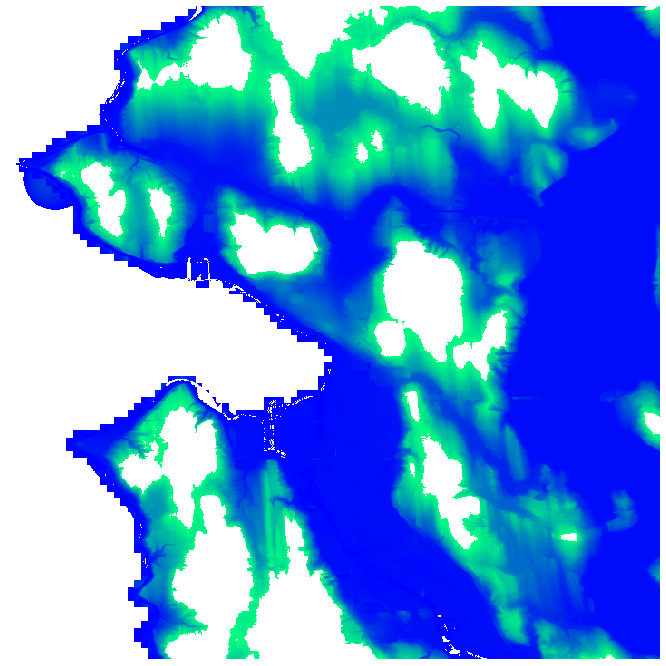

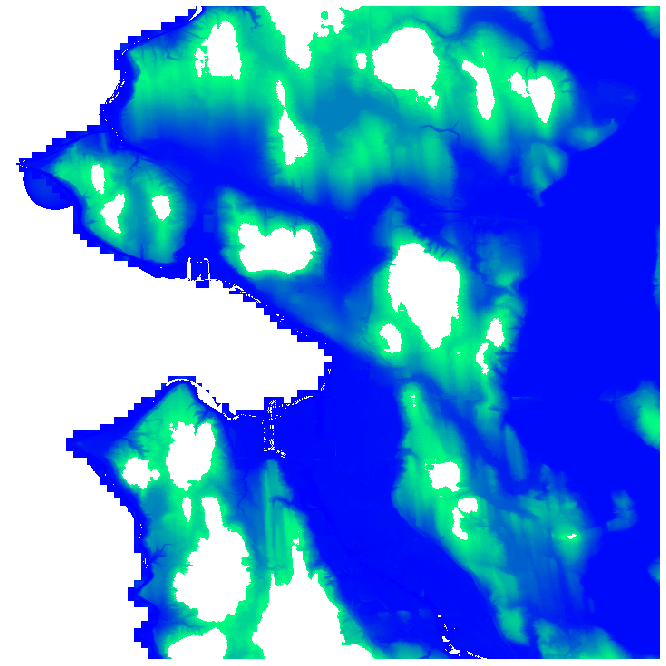

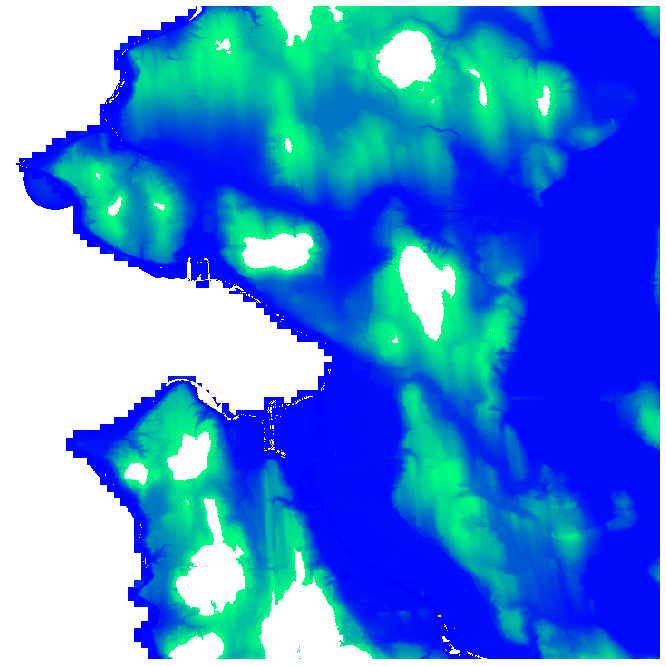

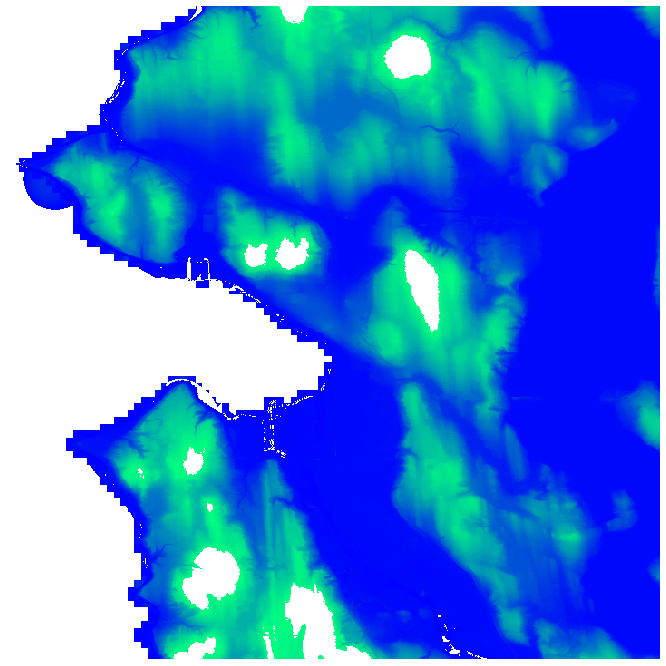

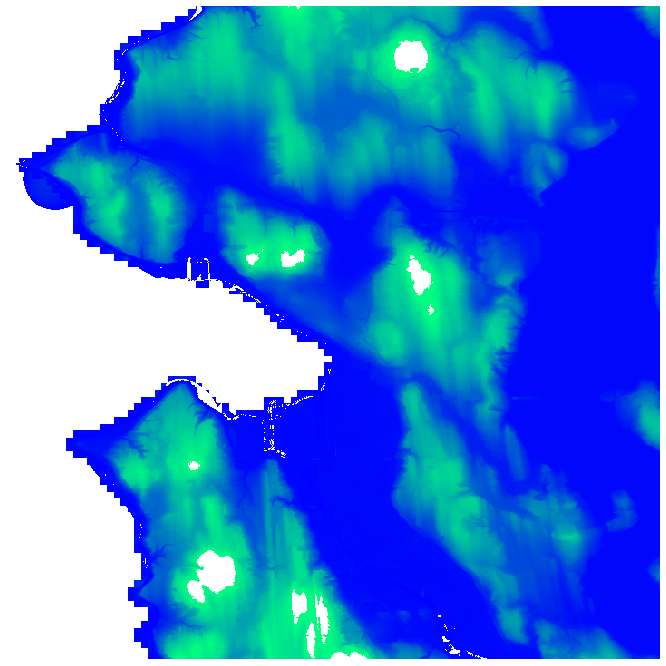

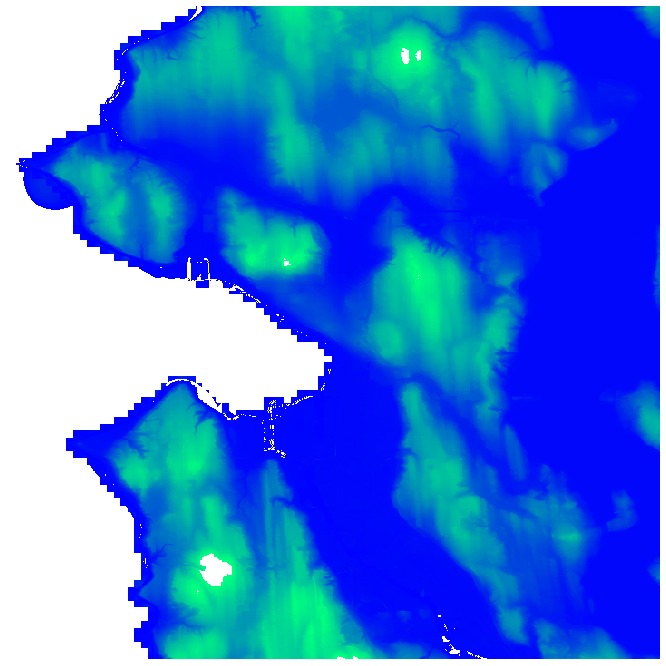

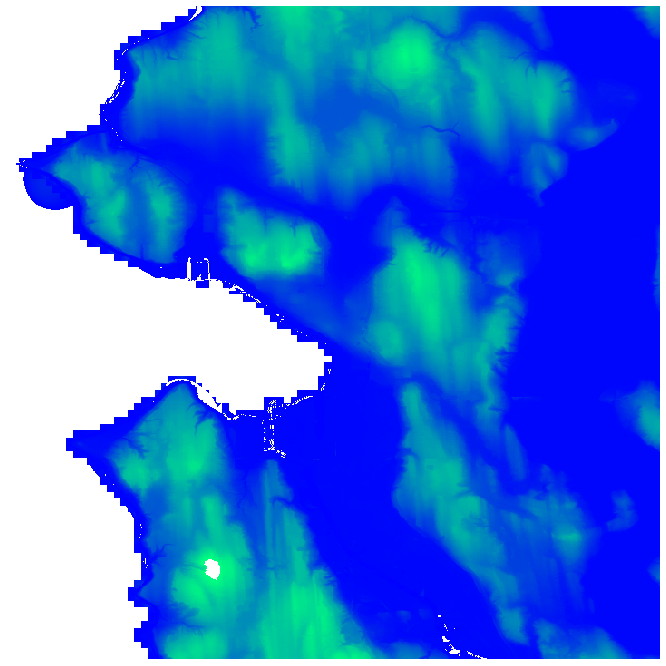

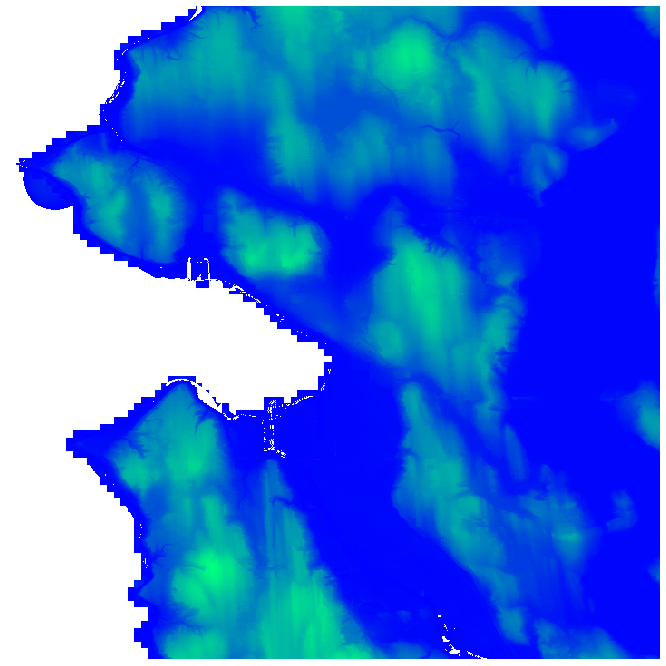

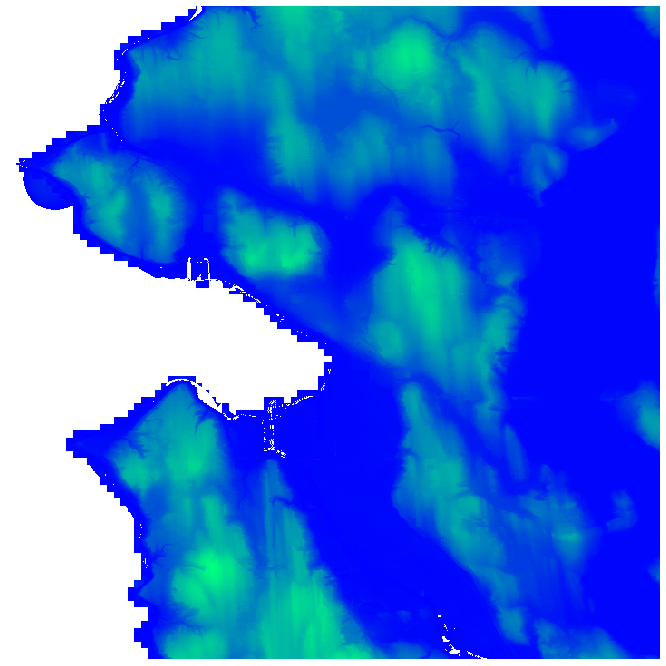

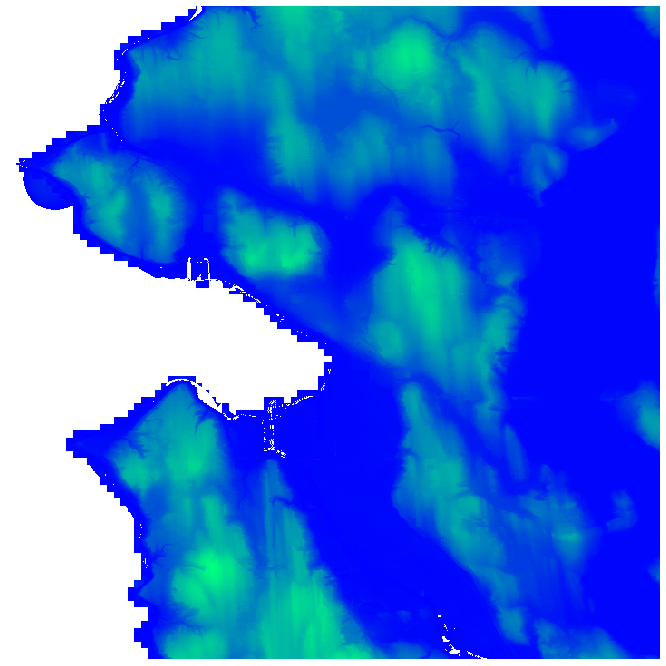

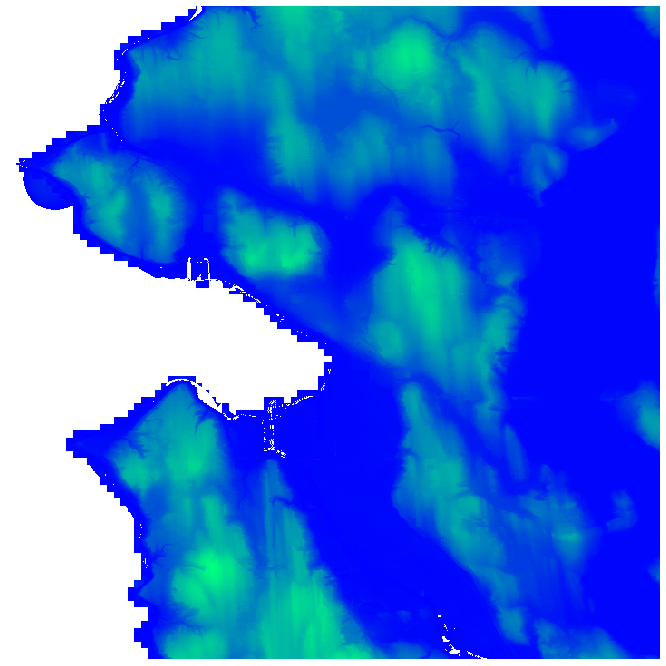

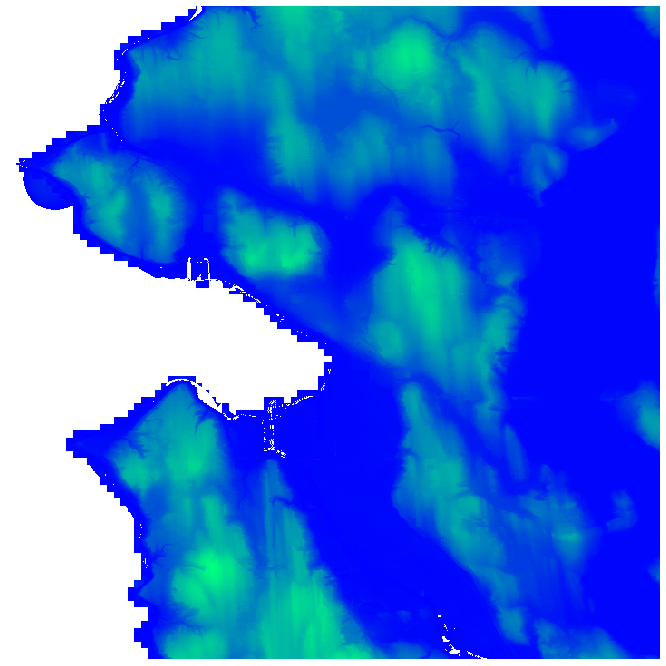

In [270]:
#output each mask as it's own image

path = "masks/seattle_"

water_colors = [
    "#dde8f0",
    "#97cbdc",
    "#018abd",
    "#004581",
    "#001b48"
]

# viridisBig = matplotlib.cm.get_cmap('viridis', 512)
# newcmp = ListedColormap(viridisBig(np.linspace(0.25, 0.75, 256)))

for level in sparse_levels:
    nl = level + step
    m = matrices[nl]

    #mask anywhere that has 0
    zeros = np.ma.masked_where(m == 0, m)
    zeros = np.flip(zeros, axis=0)

    fig = plt.figure(figsize = (12, 12), frameon=False)
    plt.imshow(zeros, cmap="winter", interpolation='none')
    plt.axis('off')
    filename = path+str(level)+".png"
    plt.savefig(filename, transparent=True)